# Model Exploration

In this notebook, we plot the RGB, DSM, and DTM data side by side, and layer the ground-truth mask as well as the predicted mask over the RGB data. We also present the accuracy metrics of the model on the RGB + DSM/DTM data.

In [12]:
import matplotlib.pyplot as plt
import cv2
import numpy as np
import georaster
import torch
import json
from pytorch_utils.eval import read_model, flip
from nbutils import thresh, score_pred, load_img, make_input_tensor, predict_on_file, get_saliency_big, plot_poly
from config import Config
%matplotlib inline

Albu's final solution uses 4 channels (RGB and (DSM - DTM)), but his model begins training with only RGB data. It's possible to try using only 3 channels.

In [2]:
cfg_f = '../resnet34_1x1080_retrain.json'
with open(cfg_f, 'r') as f:
    cfg = json.load(f)
cfg = Config(**cfg)
# When we have satellite imagery & depth-mapping
# See end of file for attempt at using only imagery
model = read_model(cfg, 4)

### Examine the Satellite Imagery and Depth Mapping

If you'd like to save the figure for more detailed exploration, uncomment the line below

Note: we can actually plot the corresponding latitude & longitude for each axis, but it introduces distortion.


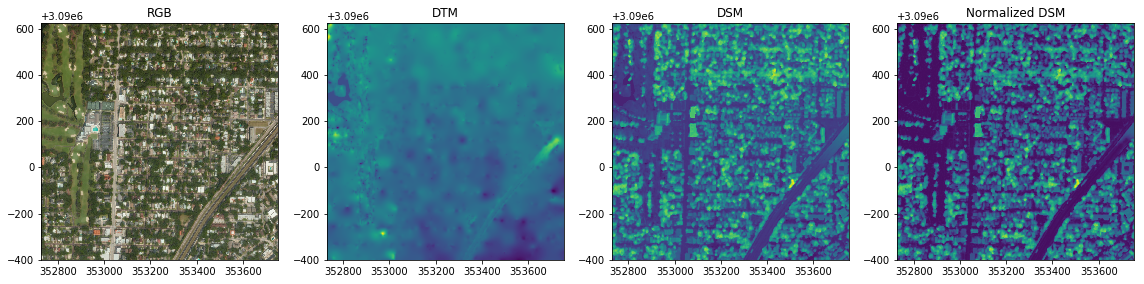

In [3]:
fname = '../../Train/Inputs/TAM_Tile_099_RGB.tif'
dsmname = fname.replace('RGB', 'DSM')
dtmname = fname.replace('RGB', 'DTM')
img = load_img(fname, tiff=False)
fig, axes = plt.subplots(ncols=4, figsize=(16,8))
geo_img = georaster.MultiBandRaster(fname, load_data=False)
dtm_img = georaster.SingleBandRaster(dtmname).r
dsm_img = georaster.SingleBandRaster(dsmname).r
dem_img = (dsm_img - dtm_img) / 9.0
axes[0].imshow(img, extent=geo_img.extent)
axes[0].set_title("RGB")
axes[1].imshow(dtm_img, extent=geo_img.extent)
axes[1].set_title("DTM")
axes[2].imshow(dsm_img, extent=geo_img.extent)
axes[2].set_title("DSM")
axes[3].imshow(dem_img, extent=geo_img.extent)
axes[3].set_title("Normalized DSM")
fig.tight_layout()
# fig.savefig('Satellite+Depth.png', dpi=200)
print("""Note: we can actually plot the corresponding latitude & longitude for each axis, but it introduces distortion.""")

### Create Polygons from Ground Truth Labels

63 0 0.5931944847106934


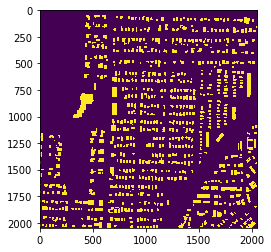

In [4]:
lblname='../../Train/GT/TAM_Tile_099_GTL.tif'
geo_lbl = georaster.SingleBandRaster(lblname)
lbl = geo_lbl.r - 2
plt.imshow(lbl, extent=geo_lbl.extent)
print(lbl.max(), lbl.min(), lbl.mean())
retval, dst = cv2.threshold(lbl, 0.5, maxval=lbl.max(), type=0)
plt.imshow(dst)

### Combining the Satellite Imagery with Polygon Labels

Here we develop some tools that will plot ground truth & predicted polygon labels. In the following portions, we will develop the ability to predict using the model.

In [5]:
TRUE_COLOR = (0, 0.2, 0.9, 0.6)
PRED_COLOR = (0, 0.9, 0, 0.4)

#### An example with the ground truth

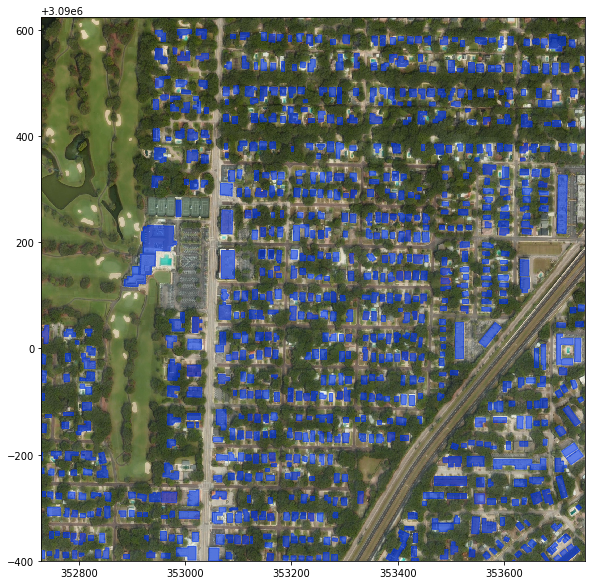

In [6]:
fig, ax = plt.subplots(figsize=(10, 10))
plt.imshow(img, extent=geo_img.extent)
plot_poly(contours, ax, geo_img.coordinates, TRUE_COLOR)
plt.show()

#### Predicting with the pretrained model

We replicate a few ensembling and averaging techniques traditionally used to improve ensemble accuracy, however, there we are still missing some of the subtlety to Albu's solution. Albu trains 5 models on 5 different folds of the dataset, and ensembles their predictions on the flips. We, however, are only using 1 model from the last of the 5 folds. Here we use window-crops.

It's worth noting that the accuracy differs between these different methods. In theory, I don't think there should be this much variation, but I don't have that much experience in this yet.

In [7]:
ckpt = torch.load('results/weights/resnet34_/fold4_checkpoint.pth')

In [8]:
output = predict_on_file(model, fname, crop=True)
print("F1 / IOU with crop + flip:", 
      score_pred(thresh(output),lbl))
print("F1 / IOU with no crop + flip:", 
      score_pred(thresh(predict_on_file(model, fname, crop=False)), lbl))
print("F1 / IOU with no crop + no flip:",
     score_pred(thresh(predict_on_file(model, fname, crop=False, flips=flip.FLIP_NONE)), lbl))

/home/ngundotra/.conda/envs/gdal/lib/python3.6/site-packages/torch/nn/modules/upsampling.py:129: UserWarning: nn.Upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.{} is deprecated. Use nn.functional.interpolate instead.".format(self.name))
/home/ngundotra/.conda/envs/gdal/lib/python3.6/site-packages/torch/nn/functional.py:1332: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


F1 / IOU with crop + flip: 0.8203026677460877
F1 / IOU with no crop + flip: 0.8213457076566125
F1 / IOU with no crop + no flip: 0.8224054428593426


## Comparing Predicted with Ground Truth

The blue represents the ground truth, and the yellow-green represents the predicted solutions from cropping & flipping with Albu's model from the last fold of the dataset.

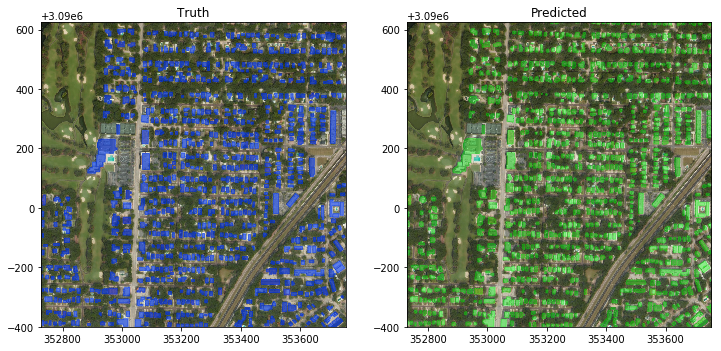

In [32]:
get_ctr = lambda out: cv2.findContours(cv2.threshold(out, 127, 255, 0)[1], 
                                           cv2.RETR_TREE,
                                           cv2.CHAIN_APPROX_SIMPLE)[1]
fig, ax = plt.subplots(figsize=(12, 6), ncols=2)
ax[0].imshow(img, extent=geo_img.extent)
plot_poly(get_ctr(lbl*255), ax[0], geo_img.coordinates, TRUE_COLOR)
ax[1].imshow(img, extent=geo_img.extent)
ax[1].set_title("Predicted")

plot_poly(get_ctr(output), ax[1], geo_img.coordinates, PRED_COLOR)

Here we combine the plots, which makes it easy to spot where the model failed to label entire buildings.

In [55]:
def plot_poly_saliency(fname, lblname, model):
    img = load_img(fname)
    dsm = georaster.SingleBandRaster(fname.replace("RGB", "DSM")).r
    dtm = georaster.SingleBandRaster(fname.replace("RGB", "DTM")).r
    dem_img = (dsm - dtm) / 9.0
    del(dsm)
    del(dtm)
    geo_img = georaster.SingleBandRaster(lblname)
    lbl = geo_img.r - 2
    output = predict_on_file(model, fname)
    get_ctr = lambda out: cv2.findContours(cv2.threshold(out, 127, 255, 0)[1], 
                                           cv2.RETR_TREE,
                                           cv2.CHAIN_APPROX_SIMPLE)[1]
    fig, ax = plt.subplots(figsize=(15,10), ncols=2)
    left, right = ax
    left.imshow(img, extent=geo_img.extent)
    plot_poly(get_ctr(lbl*255), left, geo_img.coordinates, TRUE_COLOR)
    plot_poly(get_ctr(output), left, geo_img.coordinates, PRED_COLOR)
    left.set_title("F1/IOU = {0:<.5f}".format(score_pred(output, lbl)))

    plt.figure(figsize=(8,8))
    sal = get_saliency_big(model, torch.Tensor(make_input_tensor(img, dem_img)), lbl)
    right.imshow(cv2.cvtColor((sal * 255).astype(np.uint8), cv2.COLOR_GRAY2RGB), cmap='gray', 
               extent=geo_img.extent)
    PRED_LIGHT = (*PRED_COLOR[:-1], 0.05)
    plot_poly(get_ctr(output), right, geo_img.coordinates, PRED_LIGHT)
    right.set_title("Saliency Map with Predicted labels")
    return fig, ax

/home/ngundotra/.conda/envs/gdal/lib/python3.6/site-packages/torch/nn/modules/upsampling.py:129: UserWarning: nn.Upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.{} is deprecated. Use nn.functional.interpolate instead.".format(self.name))
/home/ngundotra/.conda/envs/gdal/lib/python3.6/site-packages/torch/nn/functional.py:1332: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


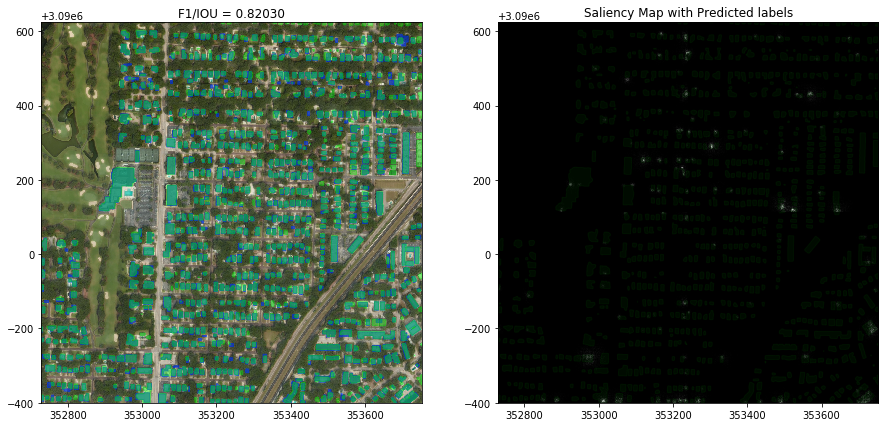

<Figure size 576x576 with 0 Axes>

In [54]:
fig, ax = plot_poly_saliency(fname, lblname, model)

../../Train/Inputs/JAX_Tile_095_RGB.tif ../../Train/GT/JAX_Tile_095_GTL.tif


/home/ngundotra/.conda/envs/gdal/lib/python3.6/site-packages/torch/nn/modules/upsampling.py:129: UserWarning: nn.Upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.{} is deprecated. Use nn.functional.interpolate instead.".format(self.name))
/home/ngundotra/.conda/envs/gdal/lib/python3.6/site-packages/torch/nn/functional.py:1332: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


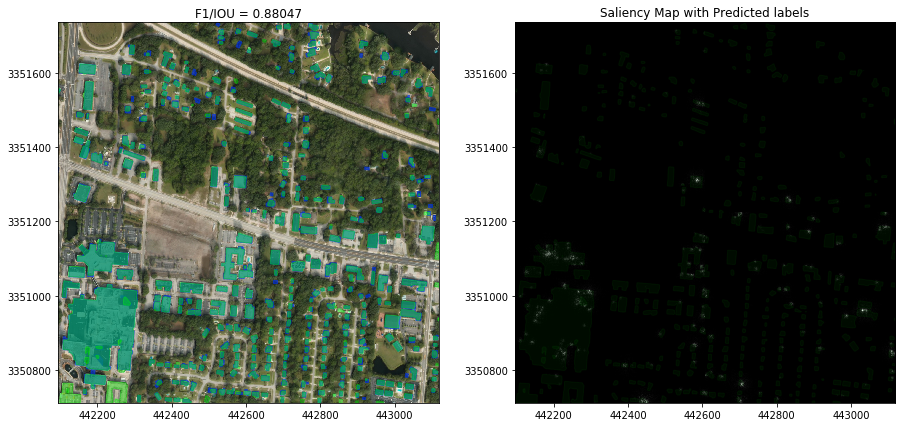

<Figure size 576x576 with 0 Axes>

In [62]:
import os
indir = '../../Train/Inputs/'
truthdir = '../../Train/GT/'
name = np.random.choice(os.listdir(indir))
name = name[:-7] + 'RGB.tif'
random_rgbf, random_lblf = indir+name, truthdir+name.replace("RGB","GTL")
print(random_rgbf, random_lblf)
fig, ax = plot_poly_saliency(random_rgbf, random_lblf, model)
fig.savefig(name, dpi=150)

In [ ]:
!ls ../../Train/GT/